In [19]:
import anndata as ad

PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_single_cell__label_cell_type__processed.h5ad'
# PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_donor_id__label_cell_type__processed.h5ad'

adata_predict = ad.read_h5ad(PATH)
nbins = adata_predict.uns['nbins']
results = adata_predict.uns['results']

In [22]:
adata_predict

AnnData object with n_obs × n_vars = 144885 × 5792
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'label', 'n_genes', 'train', 'marker_gene', 'marker_feature_name'
    var: 'soma_joinid', 'feature_name', 'feature_length', 'column_1', 'column_2', 'column_3', 'column_4', 'external_gene_name', 'gene_biotype', 'train'
    uns: 'nbins', 'preprocessing', 'rank_genes_groups', 'results', 'var_embedding_pca'
    varm: 'amax_tss_embedding', 'embedding', 'embedding_pca'
    layers: 'confidence', 'predicted', 'target'

In [23]:
print(
    f"""
    mean spearman across genes {results['spearman_obs_mean']:.3f}
    mean spearman across cells {results['spearman_var_mean']:.3f}
    """
)


    mean spearman across genes -0.000
    mean spearman across cells -0.011
    


In [24]:
# import numpy as np
# cm = results['confusion_matrix']
# print(cm.sum(axis=1))
# X = cm / cm.sum(axis=1)[:, np.newaxis]

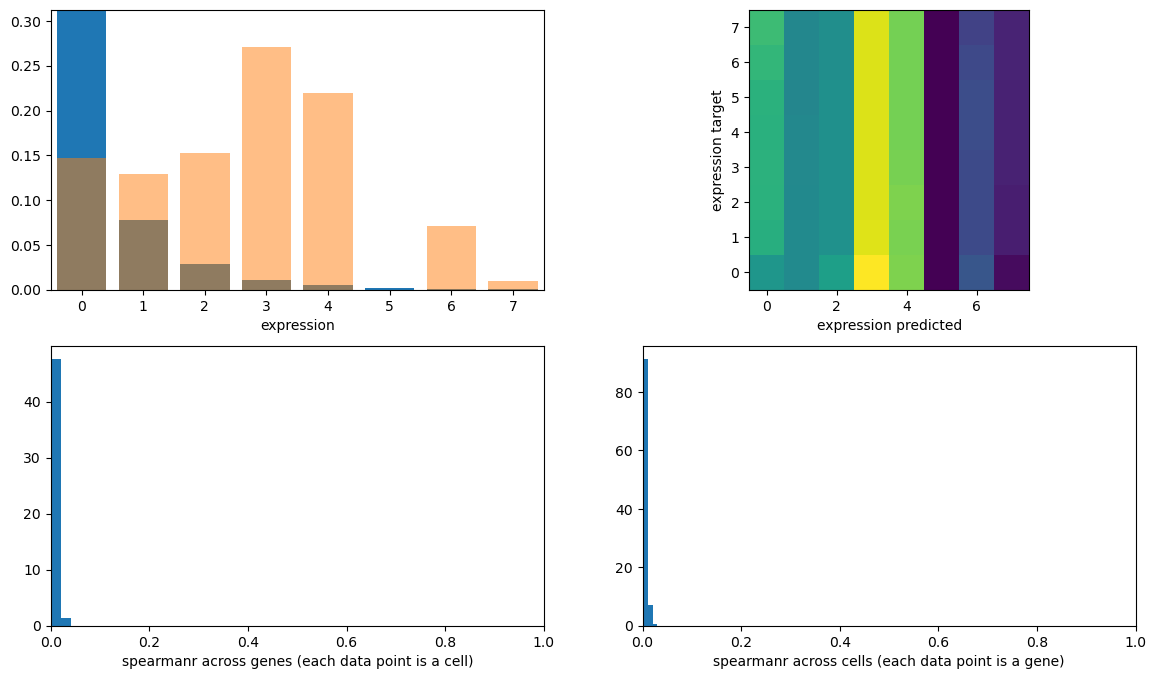

In [25]:
from rosa.utils import plot_expression_and_correlation, plot_marker_gene_heatmap
  
plot_expression_and_correlation(results)

         Falling back to preprocessing with `sc.pp.pca` and default params.


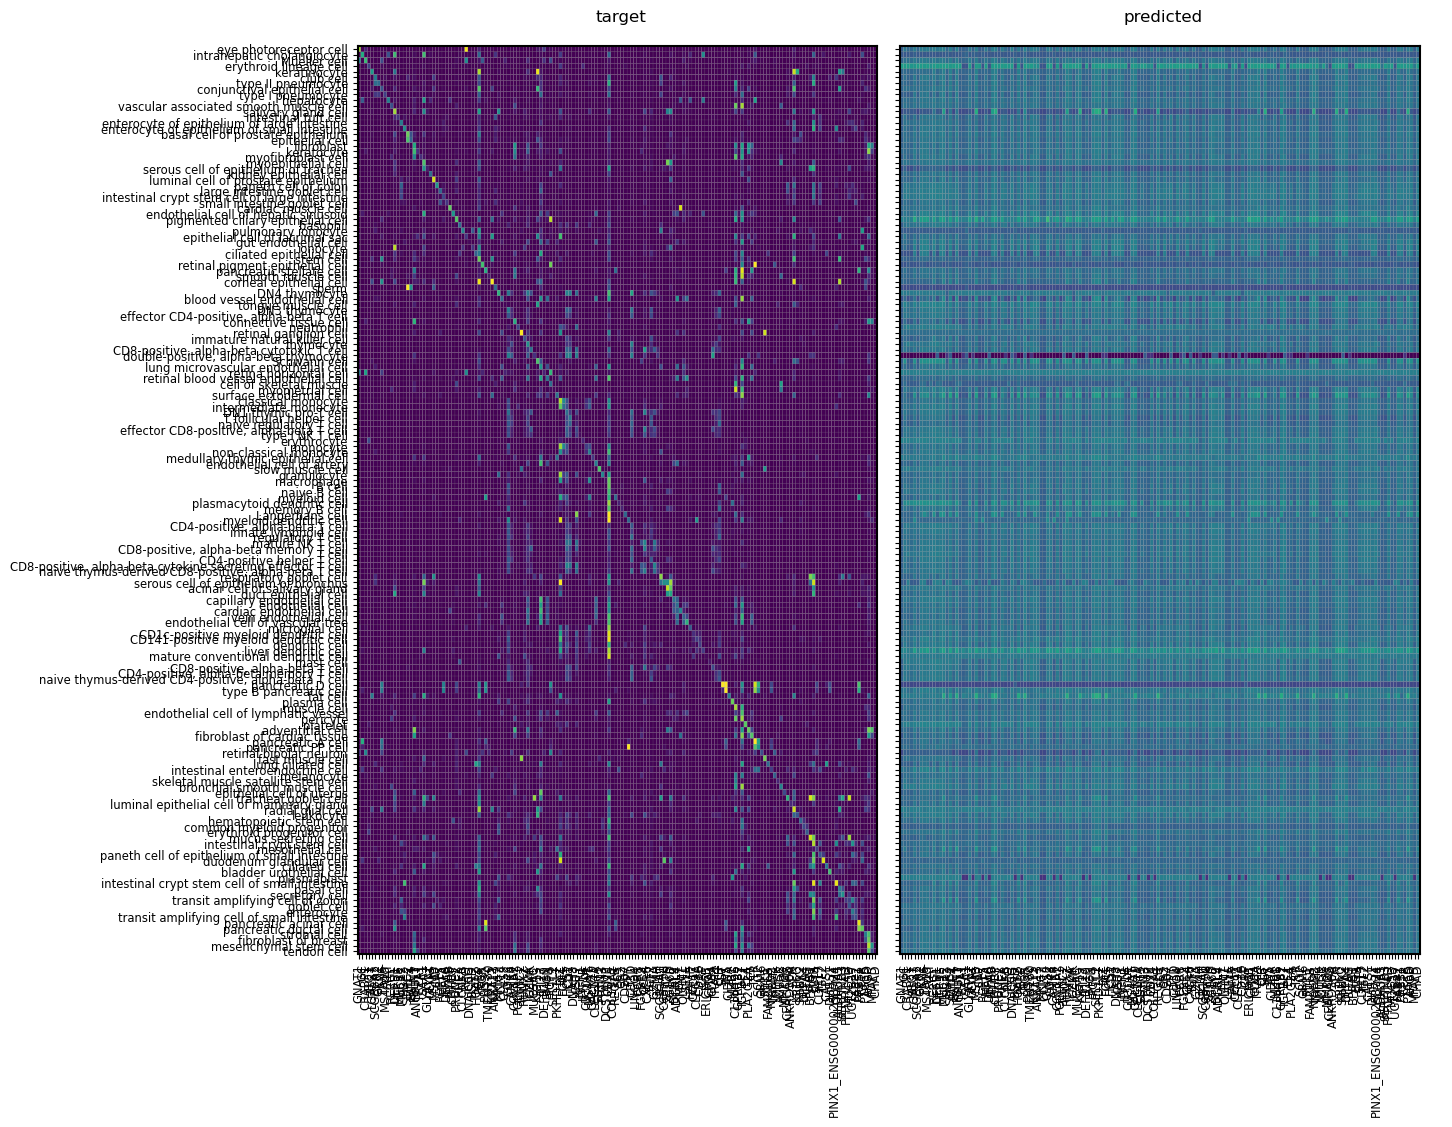

In [26]:
import scanpy as sc

marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']
sc.tl.dendrogram(adata_predict, groupby="label")
plot_marker_gene_heatmap(adata_predict, marker_genes_dict)

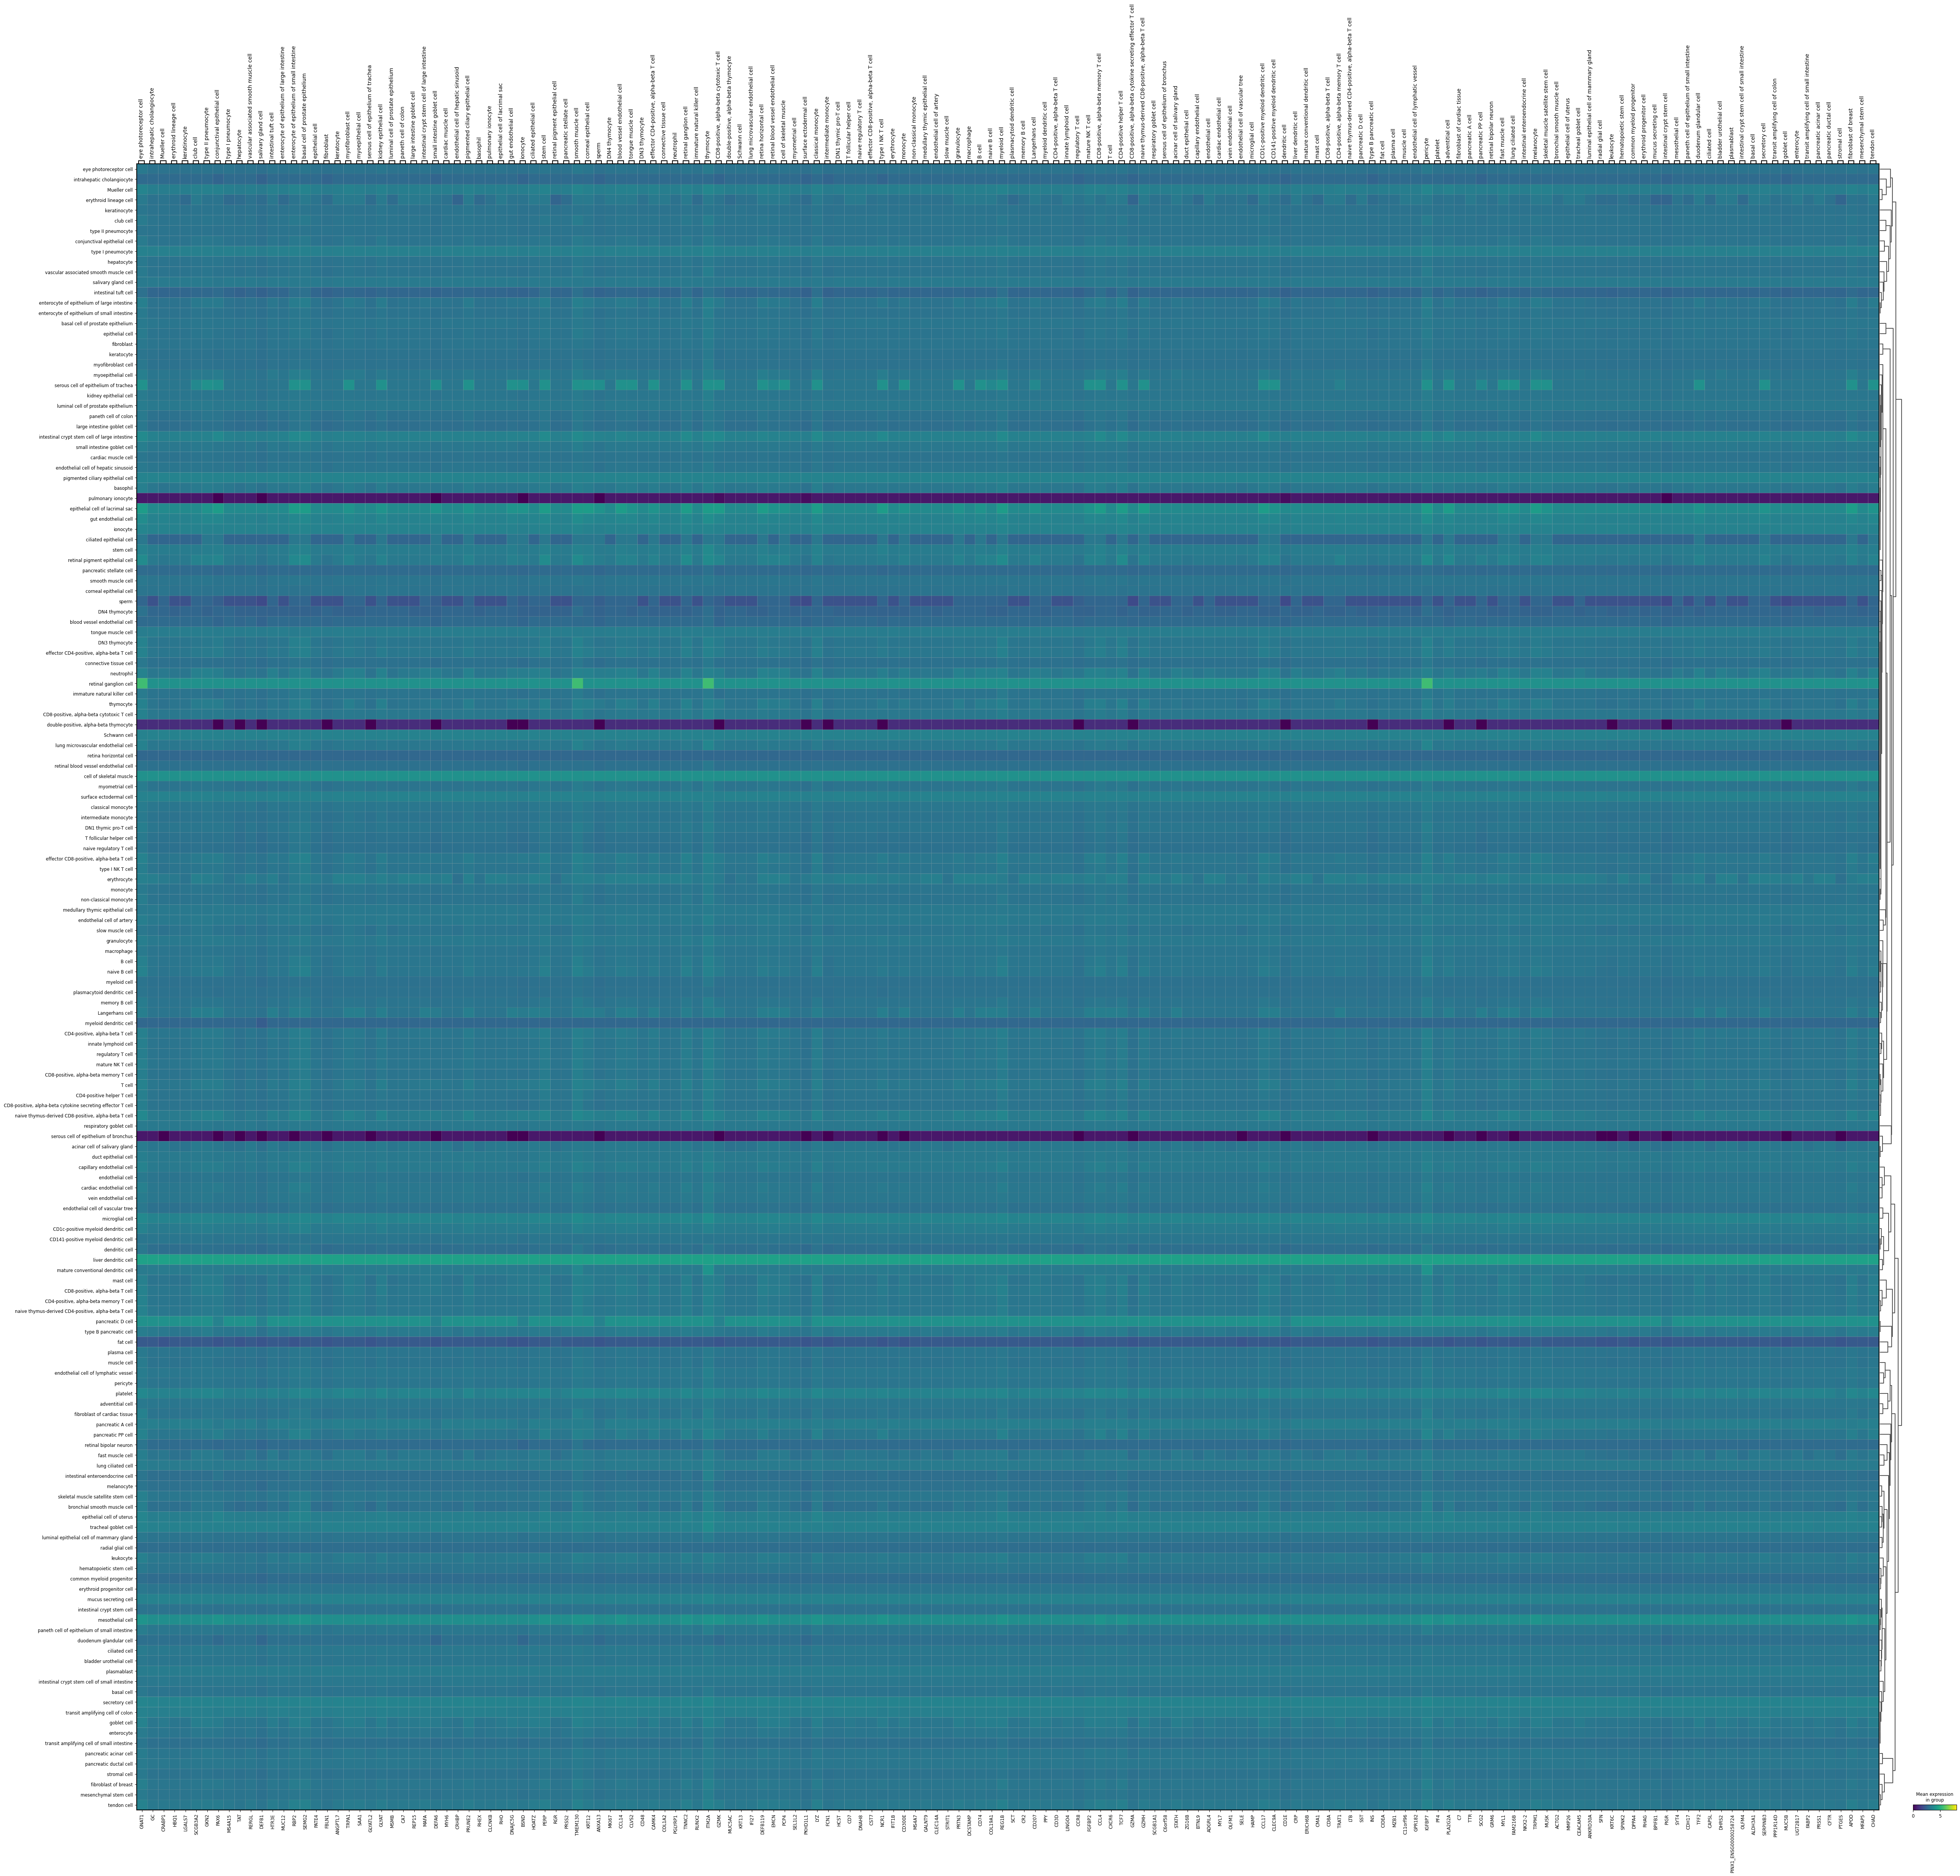

In [8]:
a = sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer="predicted",
    vmin=0,
    vmax=8,
    show=False,
    dendrogram=True,
)

In [9]:
from scanpy.plotting._matrixplot import MatrixPlot

In [11]:
mp_c = MatrixPlot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer="confidence",
    vmin=0,
    vmax=7,
    show=False,
    dendrogram=False,
)

In [12]:
mp_p = MatrixPlot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer="target",
    vmin=0,
    vmax=7,
    show=False,
    dendrogram=True,
)

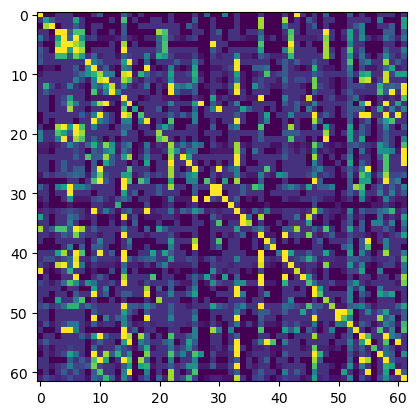

In [79]:
import matplotlib.pyplot as plt
plt.imshow(mp_p.values_df.values)

In [80]:
mp_p.add_dendrogram(dendrogram_key=True)

_color_df = mp_p.values_df.copy()
if mp_p.var_names_idx_order is not None:
    _color_df = _color_df.iloc[:, mp_p.var_names_idx_order]

if mp_p.categories_order is not None:
    _color_df = _color_df.loc[mp_p.categories_order, :]

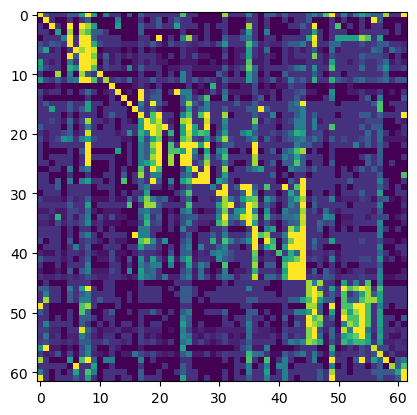

In [81]:
import matplotlib.pyplot as plt

plt.imshow(_color_df)

In [7]:
import torch

target = torch.from_numpy(adata_predict.layers['target'])
preds = torch.from_numpy(adata_predict.layers['predicted'])
conf = torch.from_numpy(adata_predict.layers['confidence'])
num_classes = adata_predict.uns['nbins']

In [8]:
unique_mapping = target.to(torch.long) * num_classes + preds.to(torch.long)
cm = torch.bincount(unique_mapping.ravel(), minlength=num_classes**2).reshape(num_classes, num_classes).numpy()

In [9]:
cm_conf = torch.bincount(unique_mapping.ravel(), weights=conf.ravel(), minlength=num_classes**2).reshape(num_classes, num_classes).numpy()
cm_conf = cm_conf / cm

Text(0.5, 1.0, 'confusion matrix with confidence transparency')

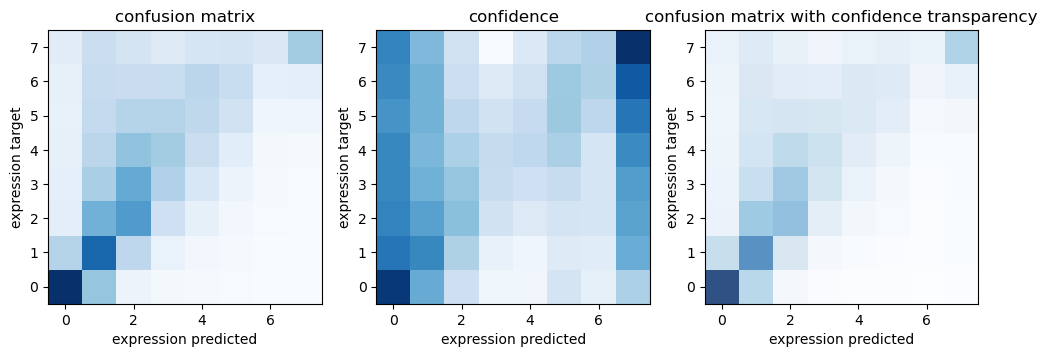

In [46]:
import numpy as np
import matplotlib.pyplot as plt


bins = np.arange(nbins)
xlim = [-0.5, num_classes - 0.5]

_, axs = plt.subplots(1, 3, figsize=(12, 6), gridspec_kw={"wspace": 0.2})

# Subplot with confusion matrix
axs[0].imshow(cm / cm.sum(axis=1)[:, np.newaxis], cmap='Blues')
axs[0].set_xlim(xlim)
axs[0].set_ylim(xlim)
axs[0].set_aspect("equal", adjustable="box")
axs[0].set_xlabel("expression predicted")
axs[0].set_ylabel("expression target")
axs[0].set_title("confusion matrix")

axs[1].imshow(cm_conf, cmap='Blues')
axs[1].set_xlim(xlim)
axs[1].set_ylim(xlim)
axs[1].set_aspect("equal", adjustable="box")
axs[1].set_xlabel("expression predicted")
axs[1].set_ylabel("expression target")
axs[1].set_title("confidence")

axs[2].imshow(cm / cm.sum(axis=1)[:, np.newaxis], alpha=cm_conf, cmap='Blues')
axs[2].set_xlim(xlim)
axs[2].set_ylim(xlim)
axs[2].set_aspect("equal", adjustable="box")
axs[2].set_xlabel("expression predicted")
axs[2].set_ylabel("expression target")
axs[2].set_title("confusion matrix with confidence transparency")

In [11]:
marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']

In [12]:
marker_genes_dict

{'B cell': 'MS4A1',
 'CD141-positive myeloid dendritic cell': 'IDO1',
 'CD1c-positive myeloid dendritic cell': 'CCL17',
 'CD4-positive, alpha-beta T cell': 'KLRB1',
 'CD8-positive, alpha-beta T cell': 'CCL5',
 'CD8-positive, alpha-beta cytokine secreting effector T cell': 'HBB',
 'CD8-positive, alpha-beta memory T cell': 'CCL4',
 'T cell': 'BCL11B',
 'acinar cell of salivary gland': 'STATH',
 'adventitial cell': 'IGFBP6',
 'basal cell': 'SFN',
 'bladder urothelial cell': 'SNCG',
 'capillary endothelial cell': 'BTNL9',
 'cardiac endothelial cell': 'ACTC1',
 'classical monocyte': 'S100A9',
 'club cell': 'WFDC2',
 'common myeloid progenitor': 'DPPA4',
 'conjunctival epithelial cell': 'MMP10',
 'connective tissue cell': 'C1S',
 'dendritic cell': 'CLEC5A',
 'effector CD4-positive, alpha-beta T cell': 'LEF1',
 'effector CD8-positive, alpha-beta T cell': 'CD8B',
 'endothelial cell': 'IFI27',
 'endothelial cell of artery': 'SEMA3G',
 'endothelial cell of lymphatic vessel': 'CCL21',
 'endotheli

In [20]:
adata_predict.obs['cell_type']

TSP5_B cell                                                                  B cell
TSP2_CD141-positive myeloid dendritic cell    CD141-positive myeloid dendritic cell
TSP10_CD1c-positive myeloid dendritic cell     CD1c-positive myeloid dendritic cell
TSP11_CD4-positive, alpha-beta T cell               CD4-positive, alpha-beta T cell
TSP2_CD8-positive, alpha-beta T cell                CD8-positive, alpha-beta T cell
                                                              ...                  
TSP15_stromal cell                                                     stromal cell
TSP2_type I pneumocyte                                            type I pneumocyte
TSP1_vein endothelial cell                                    vein endothelial cell
TSP14_vein endothelial cell                                   vein endothelial cell
TSP4_vein endothelial cell                                    vein endothelial cell
Name: cell_type, Length: 97, dtype: category
Categories (62, object): ['B ce

## Extras

In [ ]:
# import seaborn as sns
# from scipy.cluster.hierarchy import linkage
# import sys


# sys.setrecursionlimit(100000)

In [ ]:
# row_linkage = linkage(adata_predict.layers['measured']) # D being the measurement
# col_linkage = linkage(adata_predict.layers['measured'].T) # D being the measurement
# sns.clustermap(adata_predict.layers['measured'], row_linkage=row_linkage, col_linkage=col_linkage)

In [ ]:
# sns.clustermap(adata_predict.layers['predicted'], row_linkage=row_linkage, col_linkage=col_linkage)

In [ ]:
# sns.clustermap(adata_predict.layers['confidence'], row_linkage=row_linkage, col_linkage=col_linkage)

## Value histograms

In [11]:
import numpy as np

In [14]:
values, counts = np.unique(adata_predict.layers['target'], return_counts=True)

In [15]:
import matplotlib.pyplot as plt

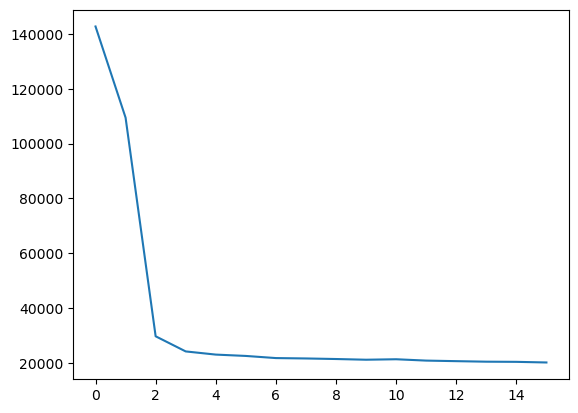

In [16]:
plt.plot(values, counts)

In [17]:
values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [18]:
counts

array([142734, 109481,  29738,  24216,  23059,  22568,  21789,  21648,
        21444,  21187,  21359,  20868,  20665,  20472,  20413,  20183])

In [19]:
import torch

In [20]:
from tqdm import tqdm

In [56]:
adata_predict.layers['counts'][:5, :5]

array([[0.0000e+00, 3.0000e+00, 3.9500e+02, 6.3600e+02, 2.6000e+01],
       [0.0000e+00, 5.9000e+01, 8.7700e+02, 1.8700e+02, 3.5000e+01],
       [0.0000e+00, 6.4500e+02, 4.0300e+02, 6.9000e+01, 2.0000e+00],
       [0.0000e+00, 4.3940e+03, 4.3400e+02, 2.2800e+02, 4.6490e+03],
       [1.0000e+00, 2.0427e+04, 6.0010e+03, 3.1360e+03, 8.2510e+03]],
      dtype=float32)

In [57]:
adata_predict.X[:5, :5]

array([[0.0000000e+00, 3.0287111e-02, 1.6191519e+00, 2.0174453e+00,
        2.3626013e-01],
       [0.0000000e+00, 5.8567297e-01, 2.5521784e+00, 1.2594682e+00,
        3.8684052e-01],
       [0.0000000e+00, 1.0091820e+00, 7.3680979e-01, 1.7100659e-01,
        5.3911968e-03],
       [0.0000000e+00, 2.7412829e+00, 8.8906699e-01, 5.6118375e-01,
        2.7941518e+00],
       [7.4058073e-04, 2.7808945e+00, 1.6948577e+00, 1.2009646e+00,
        1.9618952e+00]], dtype=float32)

In [129]:
full_binned = []
full_boundaries = []

n_bins = 8
for i, row in tqdm(enumerate(adata_predict.X)):
    tensor = torch.Tensor(row)

    boundaries = [torch.tensor(0.0)]
    for q in range(n_bins - 2):
        data_remaining = tensor[tensor>boundaries[-1]]
        n_data_remaining = len(data_remaining)
        if n_data_remaining == 0:
            next_val = boundaries[-1]
        else:
            n_bins_remaining = n_bins - q - 1
            factor = np.exp(np.log(n_data_remaining) / n_bins_remaining)
            next_quantile = 1 / 2
            next_val = max(boundaries[-1]+1e-5, torch.quantile(data_remaining, next_quantile))
            next_val = torch.quantile(data_remaining, next_quantile)
        boundaries.append(next_val)
    boundaries = torch.stack(boundaries, dim=0)

    full_binned.append(torch.bucketize(tensor, boundaries))
    full_boundaries.append(boundaries)
full_binned = torch.cat(full_binned, dim=0)
full_boundaries = torch.stack(full_boundaries)

97it [00:00, 218.53it/s]


In [130]:
full_boundaries[2]

tensor([0.0000, 0.4564, 1.5505, 2.3955, 3.1101, 3.6702, 4.1664])

In [131]:
full_boundaries[2]

tensor([0.0000, 0.4564, 1.5505, 2.3955, 3.1101, 3.6702, 4.1664])

In [132]:
full_boundaries[12]

tensor([0.0000, 0.2938, 0.8156, 1.3745, 1.9998, 2.6167, 3.2020])

In [133]:
full_boundaries[:, -1]

tensor([4.3161, 4.2326, 4.1664, 3.9993, 3.9786, 4.3486, 3.9978, 4.4019, 3.9719,
        4.0525, 3.9884, 3.9456, 3.2020, 4.1890, 4.1465, 3.8070, 3.9962, 3.7649,
        4.1978, 4.1337, 4.1600, 3.8903, 4.0302, 4.1943, 3.8770, 3.8656, 4.1491,
        4.0520, 4.3515, 3.8009, 4.0531, 4.1757, 3.9002, 3.9551, 4.0438, 4.1490,
        4.0373, 4.1005, 3.4571, 4.2474, 3.8134, 4.7266, 2.3986, 3.8582, 4.1021,
        4.2524, 4.2919, 4.8861, 4.0300, 3.8965, 4.0624, 4.0952, 4.1487, 3.9828,
        3.6180, 4.3060, 4.3220, 3.9540, 3.9855, 4.0906, 4.0493, 4.0576, 4.1036,
        3.9221, 4.1769, 3.9890, 4.0975, 4.4038, 4.2879, 3.9929, 3.9871, 4.2571,
        4.1370, 4.0859, 3.8877, 4.0021, 3.1752, 4.1024, 3.8391, 4.3199, 4.0000,
        4.1586, 4.5724, 4.0754, 3.7501, 3.8639, 4.1546, 4.0720, 3.9877, 4.0414,
        4.0251, 3.9234, 3.2611, 4.3458, 4.1813, 3.8417, 4.2187])

In [134]:
values, counts = torch.unique(full_binned, return_counts=True)

In [135]:
print(values)
print(counts)

tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([142734, 210431, 104592,  52115,  26029,  12991,   6497,   6435])


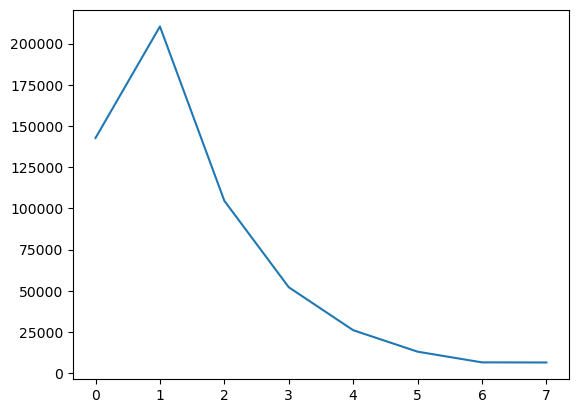

In [136]:
plt.plot(counts)

In [110]:
len(row)

5792

In [79]:
x = np.exp(np.log(5792) / 16)

In [84]:
5792 / x**15

1.7186078239135654

In [21]:
import numpy as np
from scipy.optimize import minimize_scalar

def geometric_series_r(n, Q):
    def series_sum(r):
        return (1 - r**n) / (1 - r) - Q

    res = minimize_scalar(series_sum, bounds=(0, 1), method='bounded')
    return res.x

n = 5  # Number of steps
Q = 12005  # Sum of the geometric series

r = geometric_series_r(n, Q)
print(f"Approximate value of r: {r:.5f}")


Approximate value of r: 0.00001


In [18]:
geometric_series_r(16, 5792)

4.439545990918005e-06

In [19]:
4.439545990918005e-06 + 4.439545990918005e-06^2

TypeError: unsupported operand type(s) for ^: 'float' and 'int'

In [ ]:
plt.plot(values, counts)

In [ ]:
values, counts = torch.unique(expression, return_counts=True)
nbins = self.transform[-1].n_bins
bin_counts = torch.zeros(nbins, dtype=torch.long)
bin_counts[values] = counts
mask_indices = torch.multinomial(1 / bin_counts[expression], int(self.mask * len(expression)))
mask = torch.zeros(expression.shape, dtype=torch.bool)
mask[mask_indices] = True

mask_type = torch.rand(1)
if mask_type < self.pass_through:
    pass
elif mask_type < self.corrupt:
    count_inds = torch.multinomial(counts, len(mask_indices))
    expression[mask] = values[count_inds]

In [ ]:
if torch.rand(1) < 0.3:
    print('a')

## Scanpy plots

In [ ]:
import scanpy as sc

In [ ]:
marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer=None,
    vmin=0,
    vmax=1e2,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='confidence',
    vmin=0,
    vmax=1,
    show=False,
    title='confidence',
    dendrogram=True,
)

In [ ]:
sc.pl.dotplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
marker_genes_dict_2 = {}

for key, value in list(marker_genes_dict.items())[:20]:
    marker_genes_dict_2[key] = value

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
axes = sc.pl.heatmap(
    adata_predict[:1000],
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer="measured",
    vmin=0,
    vmax=15,
    show=False,
    dendrogram=False,
)
for l in axes['heatmap_ax'].lines:
    l.remove()


In [ ]:
axes = sc.pl.heatmap(
    adata_predict[:1000],
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer="predicted",
    vmin=0,
    vmax=15,
    show=False,
    dendrogram=False,
)
for l in axes['heatmap_ax'].lines:
    l.remove()


In [ ]:
axes['heatmap_ax'].clear()

In [ ]:
for a in axes['heatmap_ax'].lines:
    print(a)

In [ ]:
axes

In [ ]:
del axes['gene_groups_ax']

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)